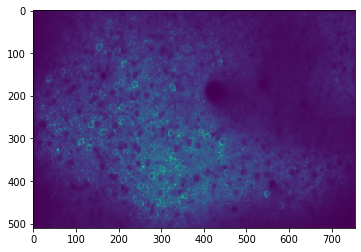

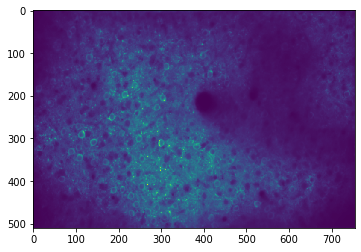

<function matplotlib.pyplot.show(*args, **kw)>

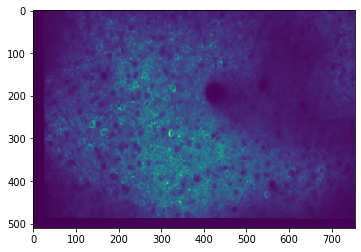

In [151]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform,ProjectiveTransform
from skimage.measure import ransac
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.transform import warp

s1path = '/Users/brianjeon/Documents/test/session1/'
s2path = '/Users/brianjeon/Documents/test/session2/'


ops1 = np.load(s1path+'ops.npy',allow_pickle = True).item() #load session 1 ops
ops2 = np.load(s2path+'ops.npy',allow_pickle = True).item() #load session 2 ops
image1border_x = ops1['xrange']
image1border_y = ops1['yrange']
image2border_x = ops2['xrange']
image2border_y = ops2['yrange']

meanImg1 = ops1['meanImg']

meanImg2 = ops2['meanImg']

plt.imshow(meanImg1)
plt.show()

plt.imshow(meanImg2)
plt.show()


# # method using SimpleElastix
# img_a = sitk.GetImageFromArray(meanImgE1_cropped)
# img_b = sitk.GetImageFromArray(meanImgE2_cropped)
# elastixImageFilter = sitk.ElastixImageFilter()
# elastixImageFilter.SetFixedImage(img_a)
# elastixImageFilter.SetMovingImage(img_b)
# elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
# elastixImageFilter.Execute()

# method 2 use skimage
descriptor_extractor = ORB(n_keypoints=500)

descriptor_extractor.detect_and_extract(meanImg1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(meanImg2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

# find matching coordinates between image1 and image2
matches_img1 = keypoints1[matches12[:,0]]
matches_img2 = keypoints2[matches12[:,1]]

model = AffineTransform()
model.estimate(matches_img1, matches_img2)

model_robust, inliers = ransac((matches_img1, matches_img2), AffineTransform, min_samples=4,
                               residual_threshold=6, max_trials=100)
outliers = inliers == False

result_vol = warp(meanImg2, model_robust.inverse, cval=-1)


transformParameterMap = elastixImageFilter.GetTransformParameterMap()
plt.imshow(result_vol)
plt.show


In [152]:
# now we create the segment mask maps for each session and apply the transform on the segment masks
stat1 = np.load(s1path+'stat.npy',allow_pickle = True)
iscell1 = np.load(s1path+'iscell.npy',allow_pickle = True)
stat2 = np.load(s2path+'stat.npy',allow_pickle = True)
iscell2 = np.load(s2path+'iscell.npy',allow_pickle = True)
#stat tupule for cells only
stat1_filt = stat1[iscell1[:,0]==1]
stat2_filt = stat2[iscell2[:,0]==1]

#create a segment mask map for the primary session
numcells_primary = len(stat1_filt) #number of cells from session1
dim_primary = np.shape(ops1['meanImg'])
segmentmask1 = np.zeros((int(dim_primary[0]),int(dim_primary[1]),int(numcells_primary)))
for a in range(numcells_primary):
    segmentmask1[stat1_filt[a]['ypix'],stat1_filt[a]['xpix'],a] =a+1
segmentmask1_flat = np.sum(segmentmask1,2)>0
# segmentmask1_flat_cropped = segmentmask1_flat[image1border_y[0]:image1border_y[1],image1border_x[0]:image1border_x[1]]

#create a segment mask map for the secondary session
numcells_secondary = len(stat2_filt)
dim_secondary = np.shape(ops2['meanImg'])
segmentmask2 = np.zeros((int(dim_secondary[0]),int(dim_secondary[1]),int(numcells_secondary)))
for a in range(numcells_secondary):
    segmentmask2[stat2_filt[a]['ypix'],stat2_filt[a]['xpix'],a] =a+1
segmentmask2_flat = np.sum(segmentmask2,2)>0
# segmentmask2_flat_cropped = segmentmask2_flat[image2border_y[0]:image2border_y[1],image2border_x[0]:image2border_x[1]]

#plt.imshow(segmentmask1_flat_cropped)
#plt.show()
#plt.imshow(segmentmask2_flat_cropped)
#plt.show()

    

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


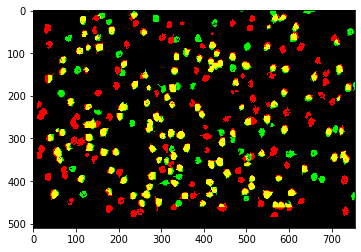

In [153]:
# now we apply the transform to the ROIs

segmentmask2_flat_tformed = warp(segmentmask2_flat, model_robust.inverse, cval=-1)

# transformix = sitk.TransformixImageFilter()
# transformix.SetTransformParameterMap(transformParameterMap)
# transformix.SetMovingImage(sitk.GetImageFromArray(1*segmentmask2_flat_cropped))

# transformix.Execute()

# transformedThirdImg = np.round(sitk.GetArrayFromImage(transformix.GetResultImage()))

combinedSegssize = np.shape(segmentmask2_flat_tformed)
# np.shape(segmentmask1_flat_cropped)

# combinedSegMap2 = segmentmask1_flat_cropped+transformedThirdImg

combinedSegMap = np.zeros((combinedSegssize[0],combinedSegssize[1],3))
combinedSegMap[:,:,0] = segmentmask1_flat
combinedSegMap[:,:,1] = segmentmask2_flat_tformed
plt.imshow(combinedSegMap)
plt.show()


In [67]:
# compute pixel overlap between each of the segment
# get all of the midpoints of the 

9